# Imports

In [11]:
# From Imports
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
from pandas import DataFrame
from datetime import datetime
from scipy.optimize import minimize
from arch import arch_model
from sklearn.linear_model import LinearRegression

# Alias Imports
import numpy_financial as npf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Imports
import math
import arch
import openpyxl 
import pprint

print("Import Complete")

Import Complete


# Importing Bond Trading Data

In [12]:
# Importing Excel data of 2Y and 10Y Tbills
tbill2Y = pd.read_excel("Treasury_Data_V1.xlsx", "T 4.625 02 28 25 Govt TRADES")
tbill10Y = pd.read_excel("Treasury_Data_V1.xlsx", "T 3.375 05 15 33 Govt TRADES")
#note, volume is traded in increments of $1000 USD at STGT Exchange
#note, need to clean 10Y data, bids / asks don't line up

# Making Trade Time, Trade Volume, and Ask Time into lists for 2Y Bond Data
dates2Y = list(tbill2Y["Trade Time"])
volumes2Y = list(tbill2Y["Trade Volume"])
asks2Y = list(tbill2Y["Ask Time"]) # Currently Not Used

print("Excel Data Imported")

Excel Data Imported


# Cleaning Bond Trading Data

In [13]:
# Cleaning Trade Time data
clean_dates2Y = []

# Going through the range and converting dates to Numpy datetime64s
for i in range(len(dates2Y)):
    date = np.datetime64(str(dates2Y[i].date()))

    # Removing all NaT values from the list
    if not np.isnat(date):

        # Adding all dates to our clean_dates2Y list
        clean_dates2Y.append(date)

    # If no date given, we make datetime max value for easy spotting
    else:
        clean_dates2Y.append(np.datetime64(datetime.max))

# Cleaning Ask Time data
clean_asks2Y = []

# Going through the range and converting dates to Numpy datetime64s
for i in range(len(asks2Y)):
    date = np.datetime64(str(asks2Y[i].date()))

    # Removing all NaT values from the list
    if not np.isnat(date):

        # Adding all dates to our clean_asks2Y list
        clean_asks2Y.append(date)

    # If no date given, we make datetime max value for easy spotting
    else:
        clean_dates2Y.append(np.datetime64(datetime.min))

print("Data cleaned")

Data cleaned


# Calculating Average Daily Volume

In [14]:
# Adding new Date object column to data
tbill2Y['Trade Time Date'] = clean_dates2Y
tbill2Y['Ask Time Date'] = clean_asks2Y

# Calculating the total volume on each specific day     
day_volumes = tbill2Y.groupby(['Trade Time Date'])['Trade Volume'].sum()

# Getting all the unique dates from Trade Time Date
unique_dates = tbill2Y['Trade Time Date'].unique()

# Creating Average Hourly Trading Volumes from Daily Volumes in Dictionary
average_volume_daily = {} #key is date, value is total_volume

# Creating dictionary around unique dates, and summed daily volumes
for day, volume in zip(unique_dates, day_volumes):
    
    # Calculate the average volume for the date and store it in the dictionary
    average_volume_daily[day] = volume / 12.0

# Splitting into lists of Dates, Volumes 
dates = average_volume_daily.keys()
hourly_volumes = average_volume_daily.values()

# Print Dates, Volumes
# print(dates)
# print(daily_volumes)

# Print the resulting dictionary
# pprint.pprint(average_volume_daily)

# Formatting Float in Pandas
pd.options.display.float_format = '{:.2f}'.format

# Print the resulting list
daily_volumes = pd.DataFrame()
daily_volumes['Trading Day'] = dates
daily_volumes['Hourly Volume'] = hourly_volumes

print("Daily Volumes")

Daily Volumes


# Simulating Price and Spread Process

In [15]:
#1) Use Cox-Ingersoll-Ross Model (CIR) model to simulate bond yield process (approximation of price process)
#2) Use GARCH model to simulate bid-ask spreads in one step ahead forecasts
#3) Z is simulated price, ask is Zu, bid is Zl, utilize to calculate daily portfolio value and loss
#4) Calculate compounded interest loss
#5) Add final portfolio loss to interest loss, print resuslts of all simulations
#OTHER NOTES#
#determine what k value we want to keep, assume constant k, $50B issue size

# Calculate instantaneous LP position value as a function of k, Zl (bid), Zu (ask), and Z (price)

In [16]:
def alpha_t(k, Z, Zl, Zu):
    xi = np.where(Zl < Z, k * (Z**0.5 - Zl**0.5), 0)
    yi = np.where(Z > Zu, k * (Zu**0.5 - Zl**0.5), 0)
    return xi + yi * Z

# Calculating Historical Midpoint between Bid and Ask

In [17]:
historical_bid_data = tbill2Y["Bid"]
historical_ask_data = tbill2Y["Ask"]
historical_midpoint = (historical_bid_data + historical_ask_data) / 2
historical_spread = abs(historical_bid_data - historical_ask_data)
# historical_midpoint

print("Calculated Historical Midpoint and Historical Spreads")

Calculated Historical Midpoint and Historical Spreads


# Calculating Price to Yield

In [18]:
def price_to_yield(price, face_value, coupon_rate, coupon_frequency, current_date, maturity_date):
    time_to_maturity_days = (maturity_date - current_date).days
    time_to_maturity_hours = time_to_maturity_days * 24  # Convert to hours
    
    full_coupon_periods = int(time_to_maturity_hours / (365.0 * 24 / coupon_frequency))
    partial_coupon_period_hours = time_to_maturity_hours % (365.0 * 24 / coupon_frequency)
    
    cash_flows = [(coupon_rate * face_value) / coupon_frequency] * full_coupon_periods
    
    # Handle the partial coupon period
    if partial_coupon_period_hours > 0:
        partial_coupon_payment = (coupon_rate * face_value * partial_coupon_period_hours) / (365.0 * 24)
        cash_flows.append(partial_coupon_payment)
    
    cash_flows[-1] += face_value  # Add the face value at maturity
    yield_value = np.nan
    
    try:
        yield_value = npf.irr([-price] + cash_flows)
    except ValueError:
        pass
    
    return yield_value

# Estimate CIR model parameters using historical yields

In [19]:
def cir_likelihood(parameters, data):
    mu, sigma, kappa, theta = parameters
    dt = 1 / (252.0 * 12)  # Hourly data assumed
    n = len(data)
    log_likelihood = 0.0
    
    for i in range(1, n):
        Zl = data[i - 1]
        Z = data[i]
        Z_diff = Z - Zl
        gamma = np.sqrt(kappa**2 + 2 * sigma**2)
        
        log_likelihood += (
            -(n - 1) * (np.log(2 * gamma) - np.log(sigma))
            - (kappa + gamma) * Z_diff
            - 2 * np.log((2 * gamma * np.exp(kappa + gamma * dt)) / (2 * gamma + (kappa + gamma) * (np.exp(gamma * dt) - 1)))
        )
    
    return -log_likelihood

initial_parameters = [0.05, 0.1, 0.2, 0.03]  # Initial guesses for parameters
result = minimize(cir_likelihood, initial_parameters, args=(historical_midpoint,), method='L-BFGS-B')
mu, sigma, kappa, theta = result.x
print(result.x)

[ 0.05        1.05484352 -0.00940215  0.03      ]


# Simulate bond yields based on the estimated CIR parameters

In [29]:
T = 1  # Time to maturity, years
n_simulations = 1000  # Num of sims
n_periods = 45  # Num of hourly periods in a year
coupon_rate = 0.04625  
coupon_frequency = 2  

simulated_yields = np.zeros((n_simulations, n_periods + 1)) #init array
bond_prices = np.zeros((n_simulations, n_periods + 1)) #init array

for i in range(n_simulations):
    dt = T / n_periods
    current_date = tbill2Y["Bid Time"][0] 
    maturity_date = current_date + pd.DateOffset(years=T)
    bond_price = historical_midpoint.iloc[0]  # Initial bond price at first midpoint value
    
    for j in range(1, n_periods):
        bond_yield = price_to_yield(bond_price, 1000, coupon_rate, coupon_frequency, current_date, maturity_date)
        Z_diff = bond_yield - historical_midpoint.iloc[j - 1]
        gamma = np.sqrt(kappa**2 + 2 * sigma**2)
        bond_yield += kappa * (theta - bond_yield) * dt + sigma * np.sqrt(bond_yield) * np.random.normal(0, np.sqrt(dt))  # CIR process
        bond_price = 1000 / ((1 + bond_yield / coupon_frequency) ** (coupon_frequency * (maturity_date - current_date).days / (365 * 24)))  # Convert yield to price
        bond_prices[i, j] = bond_price 
        simulated_yields[i, j] = bond_yield

# Replacing Spread And Volume Simulation Code

In [30]:
# Estimating OU (Ornstein–Uhlenbeck) Process Paramters for Spread Simulation

# Historical spread data is used from above calculation

# Function to calculate the OU likelihood
def ou_likelihood(parameters, data):
    mean_reversion, vol, initial_spread_min = parameters
    dt = 1  # Time step (you can adjust this based on your data frequency)
    log_likelihood = 0.0
    initial_spread = initial_spread_min
    
    for i in range(1, len(historical_spread)):
        spread_diff = historical_spread[i] - initial_spread
        log_likelihood += -0.5 * (spread_diff / vol) ** 2
        log_likelihood -= 0.5 * np.log(2 * np.pi * vol ** 2 * dt)
        initial_spread += mean_reversion * (initial_spread_min - initial_spread) * dt

    return -log_likelihood

# Initial parameter guesses
intial_mean_reversion = 0.1
intial_vol = 0.05
intial_min_arg = historical_spread[0]

# Packing them into parameter tupe
initial_parameters = (intial_mean_reversion, intial_vol, intial_min_arg)

# Minimize the negative log-likelihood to estimate OU parameters
result = minimize(ou_likelihood, initial_parameters, args=(historical_spread,), method='L-BFGS-B')
print(result)

# Extract estimated parameters
mean_reversion, volatility, initial_spread = result.x

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1849.5179356363412
        x: [ 1.000e-01 -4.808e-03  1.079e-02]
      nit: 8
      jac: [ 0.000e+00 -9.254e-03 -1.273e-03]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [31]:
#Simulating Spreads with OU Process

n_simulations = 1000  # Number of simulations
n_periods = len(historical_spread)  # Number of periods to simulate

simulated_spreads = np.zeros((n_simulations, n_periods))

for i in range(n_simulations):
    spread = initial_spread
    for j in range(n_periods):
        spread += mean_reversion * (initial_spread - spread) * dt + volatility * np.sqrt(dt) * np.random.normal(0, 1)
        simulated_spreads[i, j] = spread

In [52]:
#Simulating Volume and volume and Poisson Process

# Replace with volume data

# Calculate the average trading rate (λ) from historical data
# Calculate sums of Hourly Volume
total_historical_sum = 0
for hourly_volume in hourly_volumes:
    total_historical_sum += hourly_volume
average_historical_trading_rate = total_historical_sum / len(hourly_volumes)

# Simulate trading volume using a Poisson process
simulated_hourly_volume = np.random.poisson(average_historical_trading_rate, len(hourly_volumes))

# Calculate sums of Hourly Volume
total_simulated_sum = 0
for hourly_volume in simulated_hourly_volume:
    total_simulated_sum += hourly_volume
average_simulated_trading_rate = total_simulated_sum / len(simulated_hourly_volume)

# Adjust for daily variation (for example, increase trading rate during high-activity hours)
# Can customize this adjustment based on your market's characteristics
simulated_hourly_volume[0] *= 1.2  # Increase volume during market open
simulated_hourly_volume[-1] *= 1.2  # Increase volume during market close

# Normalize simulated volume to match historical data
np.multiply(simulated_hourly_volume, total_historical_sum / total_simulated_sum)

# Create a DataFrame to store the simulated volume data
simulated_data = pd.DataFrame({'Hourly_Volume': simulated_hourly_volume})

[0.01183212 0.01026588 0.01040398 0.01070697 0.01091254 0.01080362
 0.00992351 0.01182952 0.00913309 0.01101825 0.01111942 0.00948608
 0.01039861 0.01081803 0.0104878  0.01083792 0.00977729 0.01082038
 0.01167237 0.01132484 0.01136245 0.01032201 0.01050575 0.01109908
 0.01160226 0.01070937 0.01105111 0.01097717 0.00987496 0.00985064
 0.01020563 0.01191334 0.0099991  0.01086026 0.01180024 0.01134679
 0.01209404 0.01077132 0.01198381 0.01123135 0.01143987 0.00934699
 0.00953718 0.0101078  0.01112661 0.01004993 0.01011278 0.0110357
 0.00948603 0.01088158 0.01124046 0.01088222 0.01054955 0.01155071
 0.01187586 0.01106505 0.01091919 0.01223929 0.01036916 0.00995054
 0.01094558 0.01028748 0.01148097 0.01161066 0.00978125 0.01175746
 0.01269871 0.00993607 0.01154098 0.00997412 0.01091259 0.01066888
 0.0099     0.01036572 0.01031862 0.01125633 0.01078585 0.01150769
 0.00996301 0.01062256 0.01119831 0.01058848 0.01051952 0.01118734
 0.00977206 0.01041995 0.01034919 0.00918116 0.01156053 0.01103

In [55]:
# Rest of your code
# Calculate portfolio losses, daily profits, and total daily PnL
portfolio_losses = []  # Calculate portfolio losses based on simulated_spreads and simulated_vwap
daily_profits = []  # Calculate daily profits based on simulated_spreads and simulated_vwap
daily_opportunity_cost = []  # Calculate daily opportunity cost
total_daily_pnl = []  # Calculate total daily PnL

# k = z * y^2
y_squared = np.multiply(simulated_hourly_volume, simulated_hourly_volume)  # y^2
z = np.array(historical_midpoint[:45])  # z, z is the exchange rate (x/y) current midpoint
k = np.multiply(y_squared, z)  # z * y^2, y supply of bond, volume hourly sim

for i in range(n_simulations):
    alpha_0 = alpha_t(k, bond_prices[0, 0], simulated_spreads[i, 0] / 2, simulated_spreads[i, 0] / 2)
    split_simulated_spreads = simulated_spreads[:,0]
    portfolio_loss_i = [alpha_0 - alpha_t(k, Z, Zl, Zu) for Z, Zl, Zu in zip(bond_prices[:, 1:], simulated_spreads[i, :] / 2, simulated_spreads[i, :] / 2)]
    daily_profits_i = split_simulated_spreads[:45] * simulated_hourly_volume * fee_rate / 2  # Adjust for bid and ask
    
    # Calculate daily opportunity cost based on your formula
    daily_opportunity_cost_i = [integral_formula(alpha_0 - alpha_d, r, dt) for alpha_d, r, dt in zip(portfolio_loss_i, risk_free_rate_data, dt_values)]
    
    total_daily_pnl_i = np.array(portfolio_loss_i) + np.array(daily_opportunity_cost_i) + daily_profits_i
    
    portfolio_losses.append(portfolio_loss_i)
    daily_profits.append(daily_profits_i)
    daily_opportunity_cost.append(daily_opportunity_cost_i)
    total_daily_pnl.append(total_daily_pnl_i)

portfolio_losses = np.array(portfolio_losses)
daily_profits = np.array(daily_profits)
daily_opportunity_cost = np.array(daily_opportunity_cost)
total_daily_pnl = np.array(total_daily_pnl)

print("Complete")

/var/folders/m6/9b999tss1dv5ml49bs8bnqww0000gn/T/ipykernel_62675/413005148.py:2: RuntimeWarning: invalid value encountered in double_scalars
  xi = np.where(Zl < Z, k * (Z**0.5 - Zl**0.5), 0)
/var/folders/m6/9b999tss1dv5ml49bs8bnqww0000gn/T/ipykernel_62675/413005148.py:3: RuntimeWarning: invalid value encountered in double_scalars
  yi = np.where(Z > Zu, k * (Zu**0.5 - Zl**0.5), 0)


NameError: name 'risk_free_rate_data' is not defined

# Plot the LP PnL time series

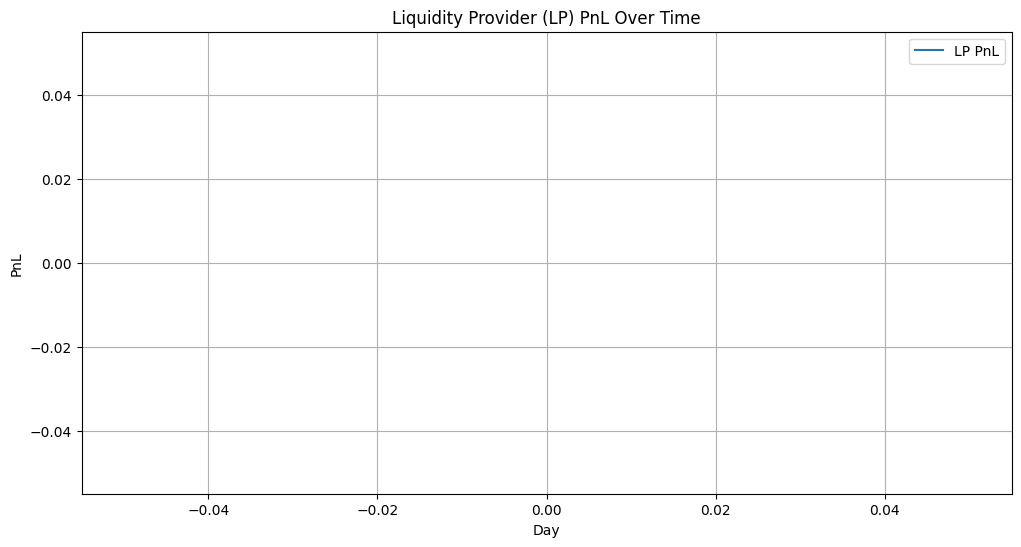

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(total_daily_pnl, label='LP PnL')
plt.title('Liquidity Provider (LP) PnL Over Time')
plt.xlabel('Day')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)
plt.show()

# Create a heatmap of LP PnL

In [35]:
plt.figure(figsize=(12, 6))
sns.heatmap(np.array([total_daily_pnl]), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Liquidity Provider (LP) PnL Heatmap')
plt.xlabel('Day')
plt.ylabel('Simulation')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x600 with 0 Axes>